# Bike Sharing Demand Prediction

https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

https://www.kaggle.com/rajmehra03/bike-sharing-demand-rmsle-0-3194


## Problem Statement

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system. <br>

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some 
factors. 

## Business Goal

Model the demand for shared bikes with the available independent variables. <br>
It will be used by the management to understand how exactly the demands vary with different features.



### Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

np.random.seed(42)
pd.set_option('max_columns', 50)
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10,7)

### Load Dataset and Data Dictionary

In [2]:
# Load Dataset
bikes_df = pd.read_csv('day.csv')
bikes_df.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [3]:
# Load Dictionary

with open('Readme.txt') as file:
    print(file.read())

Dataset characteristics
day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	
License

On understanding the dataset and the meaning of the features, we can intially drop a few features from our analysis as 
they will not add any value to the model building. <br>

1.  __instant__: Can be removed as it is just the record index.
2.  __casual__ and __registered__: Can be removed as they are jointly the Target Variabel cnt 

In [4]:
bikes_df.drop(columns=['instant','casual','registered'],inplace=True)

In [5]:
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  cnt         730 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 74.3+ KB


It appears to be the case that there are no missing values in the dataset.

### Descriptive Statistics

In [6]:
bikes_df.describe()

season          yr        mnth     holiday     weekday  workingday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     2.498630    0.500000    6.526027    0.028767    2.997260    0.683562   
std      1.110184    0.500343    3.450215    0.167266    2.006161    0.465405   
min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000    4.000000    0.000000    1.000000    0.000000   
50%      3.000000    0.500000    7.000000    0.000000    3.000000    1.000000   
75%      3.000000    1.000000   10.000000    0.000000    5.000000    1.000000   
max      4.000000    1.000000   12.000000    1.000000    6.000000    1.000000   

       weathersit        temp       atemp         hum   windspeed          cnt  
count  730.000000  730.000000  730.000000  730.000000  730.000000   730.000000  
mean     1.394521   20.319259   23.726322   62.765175   12.763620  4508.006849  
std      0.544807    7.506729    8.150308   14.237589    5.195841  1936.011647  
min      1.000000    2.424346    3.953480    0.000000    1.500244    22.000000  
25%      1.000000   13.811885   16.889713   52.000000    9.041650  3169.750000  
50%      1.000000   20.465826   24.368225   62.625000   12.125325  4548.500000  
75%      2.000000   26.880615   30.445775   72.989575   15.625589  5966.000000  
max      3.000000   35.328347   42.044800   97.250000   34.000021  8714.000000

In [7]:
bikes_df.dtypes

dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [8]:
# Extract day of the month from Dates
bikes_df['dates'] = pd.to_datetime(bikes_df.dteday,format = '%d-%m-%Y').dt.day

In [9]:
# drop dteday
bikes_df.drop(columns=['dteday'],inplace=True)

In [10]:
bikes_df.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed   cnt  dates  
0  18.18125  80.5833  10.749882   985      1  
1  17.68695  69.6087  16.652113   801      2  
2   9.47025  43.7273  16.636703  1349      3  
3  10.60610  59.0435  10.739832  1562      4  
4  11.46350  43.6957  12.522300  1600      5

Now the continous features as per the dictionary are __temp, atemp, hum, windspeed__. <br/>
And as seen from above, we do not need to make any changes to the data types for these columns.

### Handling Categorical Features

Before proceeding further we have to handle the categorical features.

1.  Replace values in categorical columns with more interpretable values rather than numerical values.
2.  Convert data type of dates column to categorical.
3.  One-Hot Encode the categorical variables.

In [11]:
bikes_df['season'] = bikes_df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

In [12]:
bikes_df['mnth'] = bikes_df.mnth.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
)

In [13]:
bikes_df['weekday'] = bikes_df.weekday.map({0:'sunday',1:'monday',2:'tuesday',3:'wednesday',4:'thursday',5:'friday',6:'saturday'})

In [14]:
bikes_df['holiday'] = bikes_df.holiday.map({0:'not_holiday',1:'holiday'})

In [15]:
bikes_df['workingday'] = bikes_df.workingday.map({0:'non_working_day',1:'working_day'})

In [16]:
# Lets decode the weathersit as follows:
# 1. Clear, Few clouds, Partly cloudy, Partly cloudy : almost_clear
# 2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist : misty
# 3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds : lighy_rain_snow
# 4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog: extreme


bikes_df['weathersit'] = bikes_df.weathersit.map({1: 'almost_clear', 2: 'misty', 3: 'light_rain_snow',4: 'extreme'})

In [17]:
bikes_df.head()

season  yr mnth      holiday    weekday       workingday    weathersit  \
0  spring   0  Jan  not_holiday   saturday  non_working_day         misty   
1  spring   0  Jan  not_holiday     sunday  non_working_day         misty   
2  spring   0  Jan  not_holiday     monday      working_day  almost_clear   
3  spring   0  Jan  not_holiday    tuesday      working_day  almost_clear   
4  spring   0  Jan  not_holiday  wednesday      working_day  almost_clear   

        temp     atemp      hum  windspeed   cnt  dates  
0  14.110847  18.18125  80.5833  10.749882   985      1  
1  14.902598  17.68695  69.6087  16.652113   801      2  
2   8.050924   9.47025  43.7273  16.636703  1349      3  
3   8.200000  10.60610  59.0435  10.739832  1562      4  
4   9.305237  11.46350  43.6957  12.522300  1600      5

In [18]:
bikes_df['dates'] = bikes_df.dates.astype('category')

In [19]:
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    object  
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    object  
 3   holiday     730 non-null    object  
 4   weekday     730 non-null    object  
 5   workingday  730 non-null    object  
 6   weathersit  730 non-null    object  
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
 12  dates       730 non-null    category
dtypes: category(1), float64(4), int64(2), object(6)
memory usage: 70.8+ KB


### Exploratory Data Analysis - Categorical Features

In [20]:
def feature_counts(df,feature,text,set_logscale=False):
    plt.title(f'Top {feature} by count',fontsize = 18)
    total_by_feature = df.groupby(feature).agg({'cnt':'sum'}).reset_index()
    g =sns.barplot(x = feature,y='cnt',data =total_by_feature)
    if set_logscale:
        g.set_yscale("log")
    plt.ylabel('Count',fontsize = 18)
    plt.xlabel(text,fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.xticks(rotation=45,fontsize = 18)
    plt.show()   

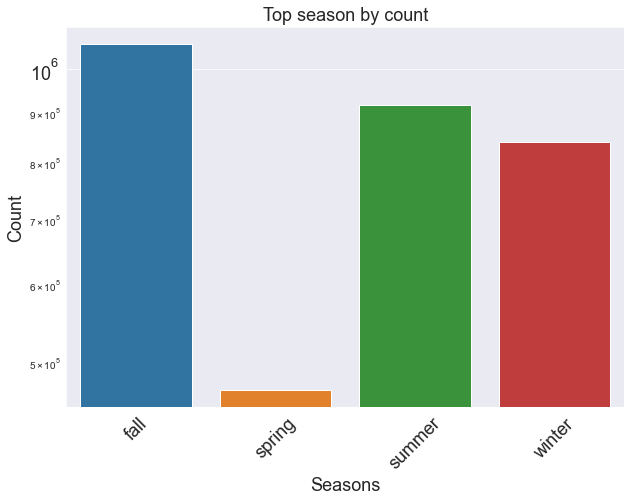

In [21]:
feature_counts(bikes_df,feature='season',text='Seasons',set_logscale=True)

Most bikes sharing data is in the Fall.

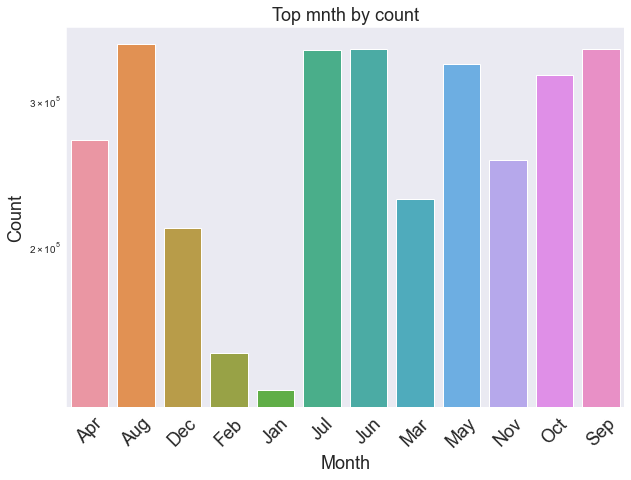

In [22]:
feature_counts(bikes_df,feature='mnth',text='Month',set_logscale=True)

As seen previosly the Fall months September - December have the highest bookings.

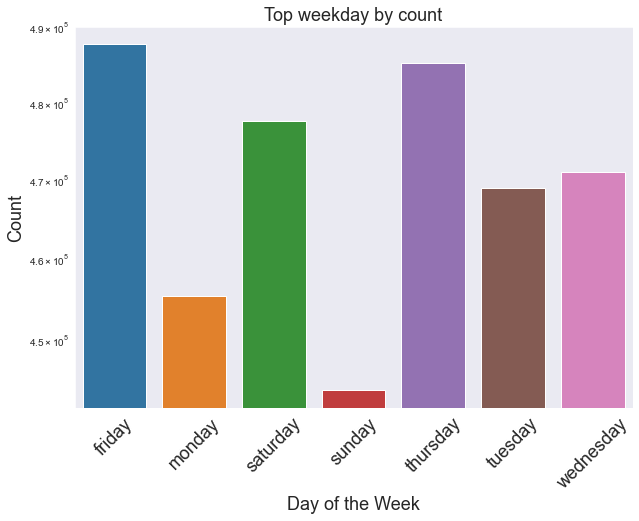

In [23]:
feature_counts(bikes_df,feature='weekday',text='Day of the Week',set_logscale=True)

Fridays see the most bookings followed by Thurdays and Sundays being the least booked day.

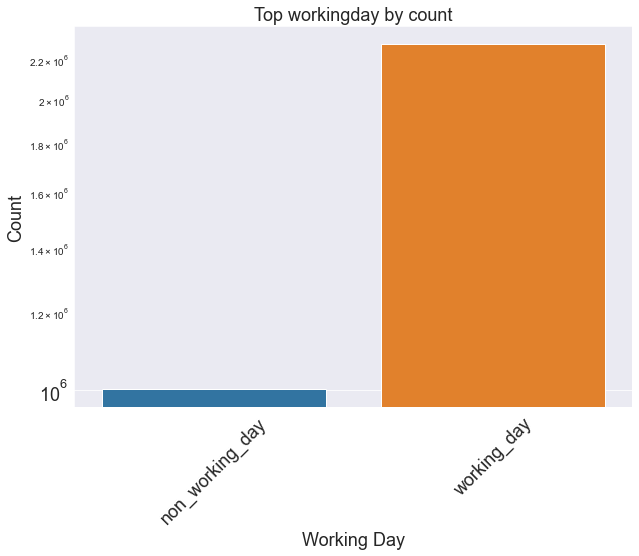

In [24]:
feature_counts(bikes_df,feature='workingday',text='Working Day',set_logscale=True)

The most bookings occur only on Working Days and not on holidays or Weekends.

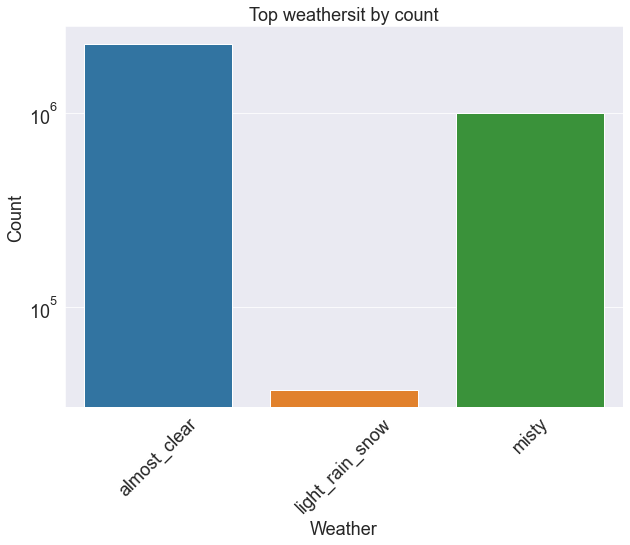

In [25]:
feature_counts(bikes_df,feature='weathersit',text='Weather',set_logscale=True)

People tend to book bikes on Clear Days rather than on Rainy/ Snow fall days.

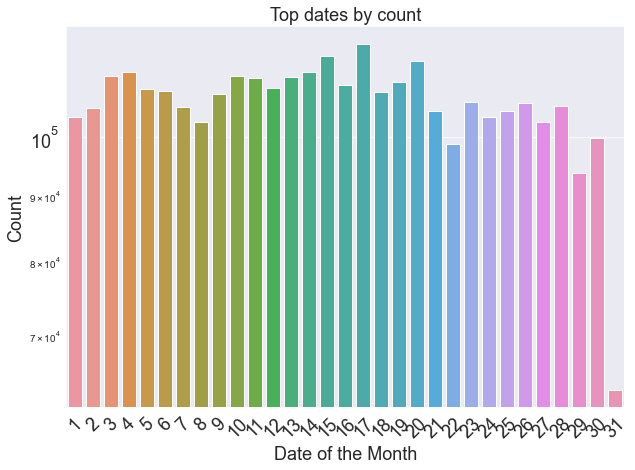

In [26]:
feature_counts(bikes_df,feature='dates',text='Date of the Month',set_logscale=True)

There is an increase in the number of bookings in the middle of the Month and it slowly weakens towards the end of the month. 

### Binning of Continous features

We will try to create new features by binning some of the Continous features for analysis.

In [27]:
pd.qcut(bikes_df.temp,4,labels=['chilly cold','cool','pleasant','hot'])

0             cool
1             cool
2      chilly cold
3      chilly cold
4      chilly cold
          ...     
725    chilly cold
726    chilly cold
727    chilly cold
728    chilly cold
729    chilly cold
Name: temp, Length: 730, dtype: category
Categories (4, object): ['chilly cold' < 'cool' < 'pleasant' < 'hot']

In [28]:
bikes_new_features_df = bikes_df.copy()
bikes_new_features_df['temp_bins'] = pd.qcut(bikes_new_features_df.temp,4,labels=['chilly cold','cool','pleasant','hot'])

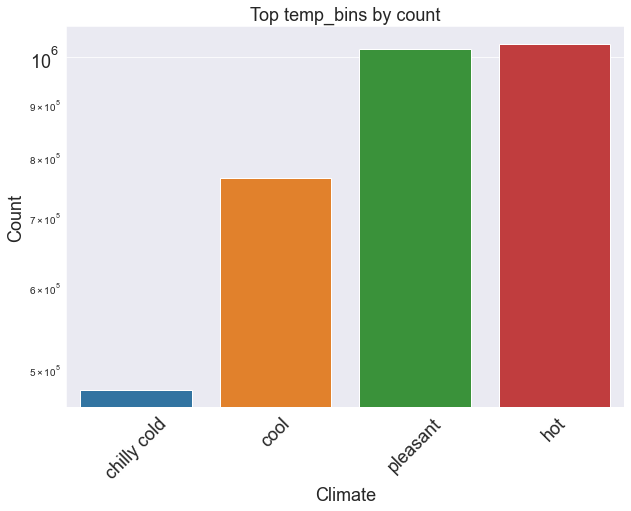

In [29]:
feature_counts(bikes_new_features_df,'temp_bins',text='Climate',set_logscale=True)

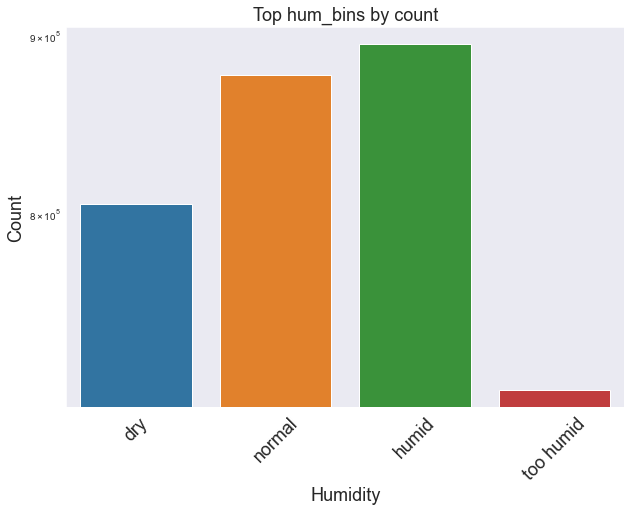

In [30]:
bikes_new_features_df['hum_bins'] = pd.qcut(bikes_new_features_df.hum,4,labels=['dry','normal','humid','too humid'])
feature_counts(bikes_new_features_df,'hum_bins',text='Humidity',set_logscale=True)

Seems like the hotter the climate, the more the number of bookings.

### Exploratory Data Analysis - Continous Features

Let us now try to analyze the distribution and correlation of continous features.

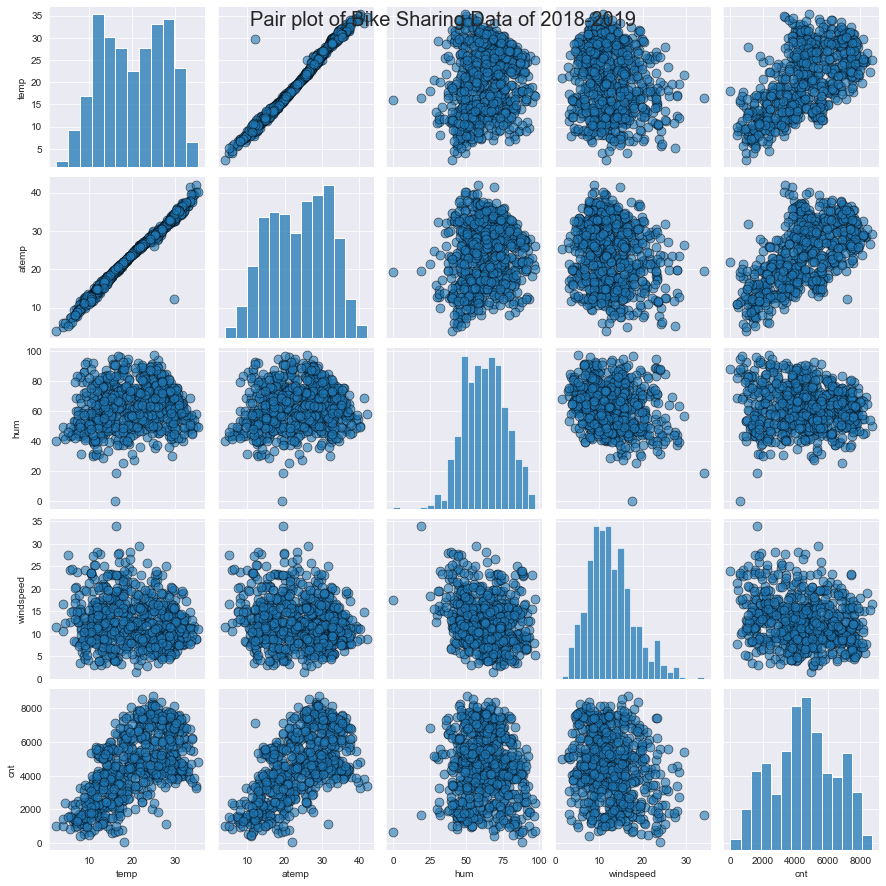

In [31]:
sns.pairplot(data=bikes_new_features_df,vars=['temp','atemp','hum','windspeed','cnt'],plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})
plt.suptitle('Pair plot of Bike Sharing Data of 2018-2019',size = 20)
plt.show()

All, the numerical variables seem to be almost normally distributed. 

There seems to be a very strong postive correlation between __temp__ and __atemp__ columns and slight correlation between these two columns and __cnt__ column.<br>
We can verify this by plotting the correlation.

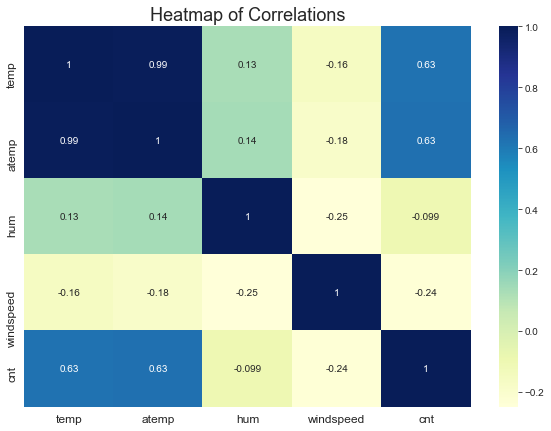

In [32]:
plt.title('Heatmap of Correlations',fontsize =18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(bikes_new_features_df[['temp','atemp','hum','windspeed','cnt']].corr(),annot=True,cmap='YlGnBu')
plt.show()

So, it is correct that temp and atemp have a high correlation and hence we can drop one of them.

In [33]:
bikes_new_features_df.drop(columns='atemp',inplace=True)

In [34]:
bikes_new_features_df.drop(columns='dates',inplace=True)

We have mapped all categories respectively, now we will convert them into one-hot encoded format.

In [35]:
bikes_categorical_df = pd.get_dummies(bikes_new_features_df,columns=['season','mnth','holiday','weekday','workingday','weathersit','temp_bins','hum_bins'],drop_first=True)

In [36]:
bikes_categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   yr                          730 non-null    int64  
 1   temp                        730 non-null    float64
 2   hum                         730 non-null    float64
 3   windspeed                   730 non-null    float64
 4   cnt                         730 non-null    int64  
 5   season_spring               730 non-null    uint8  
 6   season_summer               730 non-null    uint8  
 7   season_winter               730 non-null    uint8  
 8   mnth_Aug                    730 non-null    uint8  
 9   mnth_Dec                    730 non-null    uint8  
 10  mnth_Feb                    730 non-null    uint8  
 11  mnth_Jan                    730 non-null    uint8  
 12  mnth_Jul                    730 non-null    uint8  
 13  mnth_Jun                    730 non

In [37]:
bikes_categorical_df.head()

yr       temp      hum  windspeed   cnt  season_spring  season_summer  \
0   0  14.110847  80.5833  10.749882   985              1              0   
1   0  14.902598  69.6087  16.652113   801              1              0   
2   0   8.050924  43.7273  16.636703  1349              1              0   
3   0   8.200000  59.0435  10.739832  1562              1              0   
4   0   9.305237  43.6957  12.522300  1600              1              0   

   season_winter  mnth_Aug  mnth_Dec  mnth_Feb  mnth_Jan  mnth_Jul  mnth_Jun  \
0              0         0         0         0         1         0         0   
1              0         0         0         0         1         0         0   
2              0         0         0         0         1         0         0   
3              0         0         0         0         1         0         0   
4              0         0         0         0         1         0         0   

   mnth_Mar  mnth_May  mnth_Nov  mnth_Oct  mnth_Sep  holiday_not_holiday  \
0         0         0         0         0         0                    1   
1         0         0         0         0         0                    1   
2         0         0         0         0         0                    1   
3         0         0         0         0         0                    1   
4         0         0         0         0         0                    1   

   weekday_monday  weekday_saturday  weekday_sunday  weekday_thursday  \
0               0                 1               0                 0   
1               0                 0               1                 0   
2               1                 0               0                 0   
3               0                 0               0                 0   
4               0                 0               0                 0   

   weekday_tuesday  weekday_wednesday  workingday_working_day  \
0                0                  0                       0   
1                0                  0                       0   
2                0                  0                       1   
3                1                  0                       1   
4                0                  1                       1   

   weathersit_light_rain_snow  weathersit_misty  temp_bins_cool  \
0                           0                 1               1   
1                           0                 1               1   
2                           0                 0               0   
3                           0                 0               0   
4                           0                 0               0   

   temp_bins_pleasant  temp_bins_hot  hum_bins_normal  hum_bins_humid  \
0                   0              0                0               0   
1                   0              0                0               1   
2                   0              0                0               0   
3                   0              0                1               0   
4                   0              0                0               0   

   hum_bins_too humid  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0

### Modelling

We will create a linear model and try to capture the effect of various features with the Target variable.

In [38]:
df_train,df_test = train_test_split(bikes_categorical_df,test_size = 0.3,random_state = 42)

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numeric_features = ['temp','hum','windspeed','cnt']

df_train[numeric_features] = scaler.fit_transform(df_train[numeric_features])

In [40]:
y_train = df_train.pop('cnt')
X_train = df_train

In [41]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [42]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 10),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 15),
 ('mnth_Dec', False, 11),
 ('mnth_Feb', True, 1),
 ('mnth_Jan', False, 8),
 ('mnth_Jul', False, 9),
 ('mnth_Jun', False, 6),
 ('mnth_Mar', True, 1),
 ('mnth_May', False, 7),
 ('mnth_Nov', True, 1),
 ('mnth_Oct', True, 1),
 ('mnth_Sep', True, 1),
 ('holiday_not_holiday', True, 1),
 ('weekday_monday', False, 3),
 ('weekday_saturday', True, 1),
 ('weekday_sunday', True, 1),
 ('weekday_thursday', False, 12),
 ('weekday_tuesday', False, 2),
 ('weekday_wednesday', False, 14),
 ('workingday_working_day', True, 1),
 ('weathersit_light_rain_snow', True, 1),
 ('weathersit_misty', True, 1),
 ('temp_bins_cool', True, 1),
 ('temp_bins_pleasant', True, 1),
 ('temp_bins_hot', True, 1),
 ('hum_bins_normal', False, 5),
 ('hum_bins_humid', False, 4),
 ('hum_bins_too humid', False, 13)]

In [43]:
not_selected_cols = X_train.columns[~rfe.support_]
print(f'The unselected columns after RFE are: {list(not_selected_cols)}')

The unselected columns after RFE are: ['season_summer', 'mnth_Aug', 'mnth_Dec', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_May', 'weekday_monday', 'weekday_thursday', 'weekday_tuesday', 'weekday_wednesday', 'hum_bins_normal', 'hum_bins_humid', 'hum_bins_too humid']


It seems that the new engineered feature of hum_bins is not significant after all and is removed by RFE.

In [44]:
col = X_train.columns[rfe.support_]
print(f'The selected columns after RFE are: {list(col)}')

The selected columns after RFE are: ['yr', 'temp', 'hum', 'windspeed', 'season_spring', 'season_winter', 'mnth_Feb', 'mnth_Mar', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'holiday_not_holiday', 'weekday_saturday', 'weekday_sunday', 'workingday_working_day', 'weathersit_light_rain_snow', 'weathersit_misty', 'temp_bins_cool', 'temp_bins_pleasant', 'temp_bins_hot']


In [45]:
X_train_rfe = X_train[col]

In [46]:
def fit_linear_model(df,labels):
    df_with_const = sm.add_constant(df)
    lm = sm.OLS(labels,df_with_const).fit()   # Running the linear model
    return lm 

model = fit_linear_model(X_train_rfe,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     155.6
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          8.44e-194
Time:                        22:50:33   Log-Likelihood:                 515.57
No. Observations:                 511   AIC:                            -991.1
Df Residuals:                     491   BIC:                            -906.4
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [47]:
def get_vif_for_features(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

`mnth_Feb` has a high p-value and it is insignificant in the presence of other variables, we will remove this and refit the model again and check the summary statistics.

In [48]:
X_train_rfe = X_train_rfe.drop(['mnth_Feb'], axis=1)
model = fit_linear_model(X_train_rfe,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     163.7
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          2.18e-194
Time:                        22:50:33   Log-Likelihood:                 514.30
No. Observations:                 511   AIC:                            -990.6
Df Residuals:                     492   BIC:                            -910.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Next, we will remove the feature `mnth_Oct` as it has a high p-value and is insignificant in presence of other variables.

In [49]:
X_train_rfe = X_train_rfe.drop(['mnth_Oct'], axis=1)
model = fit_linear_model(X_train_rfe,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     172.6
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          5.74e-195
Time:                        22:50:33   Log-Likelihood:                 512.99
No. Observations:                 511   AIC:                            -990.0
Df Residuals:                     493   BIC:                            -913.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

The feature `weekday_sunday` should removed now because of high p-value and insignificance.

In [50]:
X_train_rfe = X_train_rfe.drop(['weekday_sunday'], axis=1)
model = fit_linear_model(X_train_rfe,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     172.6
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          5.74e-195
Time:                        22:50:33   Log-Likelihood:                 512.99
No. Observations:                 511   AIC:                            -990.0
Df Residuals:                     493   BIC:                            -913.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Remove `holiday_not_holiday` because of high p-value.

In [51]:
X_train_rfe = X_train_rfe.drop(['holiday_not_holiday'], axis=1)
model = fit_linear_model(X_train_rfe,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     183.3
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          7.46e-196
Time:                        22:50:33   Log-Likelihood:                 512.39
No. Observations:                 511   AIC:                            -990.8
Df Residuals:                     494   BIC:                            -918.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Now, all features have a reasonably low p-value of less than 5%.<br>
But lets have a look at the Variance Inflation Factor for each of the features in order to address multicollinearity.


In [52]:
# X_train_rfe = X_train_rfe.drop(['temp'], axis=1)
# model = fit_linear_model(X_train_rfe,y_train)
# print(model.summary())

### Variance Inflation Factor

In [53]:
print('Variance Inflation Factor of Features')
print('-'*50)
print(get_vif_for_features(X_train_rfe))

Variance Inflation Factor of Features
--------------------------------------------------
                      Features    VIF
1                         temp  77.81
2                          hum  25.55
15               temp_bins_hot  22.83
14          temp_bins_pleasant  12.74
3                    windspeed   5.62
10      workingday_working_day   4.64
13              temp_bins_cool   4.49
4                season_spring   2.94
5                season_winter   2.68
12            weathersit_misty   2.26
0                           yr   2.13
9             weekday_saturday   1.79
7                     mnth_Nov   1.73
8                     mnth_Sep   1.27
11  weathersit_light_rain_snow   1.26
6                     mnth_Mar   1.22


Looks like the `temp` feature is highly correlated with other features and we have to remove it.

In [54]:
X_train_rfe = X_train_rfe.drop(['temp'], axis=1)
model = fit_linear_model(X_train_rfe,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     193.5
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          6.59e-196
Time:                        22:50:33   Log-Likelihood:                 509.76
No. Observations:                 511   AIC:                            -987.5
Df Residuals:                     495   BIC:                            -919.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Now, all variables are still having permissible p-value. So, we will be checking VIF again.

In [55]:
print('Variance Inflation Factor of Features')
print('-'*50)
print(get_vif_for_features(X_train_rfe))

Variance Inflation Factor of Features
--------------------------------------------------
                      Features    VIF
1                          hum  18.04
2                    windspeed   5.01
9       workingday_working_day   4.42
14               temp_bins_hot   4.36
13          temp_bins_pleasant   4.02
3                season_spring   2.90
4                season_winter   2.68
12              temp_bins_cool   2.59
11            weathersit_misty   2.11
0                           yr   2.05
8             weekday_saturday   1.77
6                     mnth_Nov   1.73
7                     mnth_Sep   1.27
10  weathersit_light_rain_snow   1.21
5                     mnth_Mar   1.20


The `hum` feature is highly correlated with other features and we have to remove it.

In [56]:
X_train_rfe = X_train_rfe.drop(['hum'], axis=1)
model = fit_linear_model(X_train_rfe,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     197.3
Date:                Wed, 28 Oct 2020   Prob (F-statistic):          2.42e-192
Time:                        22:50:33   Log-Likelihood:                 498.49
No. Observations:                 511   AIC:                            -967.0
Df Residuals:                     496   BIC:                            -903.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [57]:
print('Variance Inflation Factor of Features')
print('-'*50)
print(get_vif_for_features(X_train_rfe))

Variance Inflation Factor of Features
--------------------------------------------------
                      Features   VIF
1                    windspeed  4.78
8       workingday_working_day  4.06
12          temp_bins_pleasant  2.70
13               temp_bins_hot  2.48
3                season_winter  2.29
2                season_spring  2.10
11              temp_bins_cool  2.10
0                           yr  2.05
5                     mnth_Nov  1.72
7             weekday_saturday  1.67
10            weathersit_misty  1.57
6                     mnth_Sep  1.26
4                     mnth_Mar  1.20
9   weathersit_light_rain_snow  1.11


Now, all remaining features are having p-values less than 5% and the VIF is also lesser than 5. <br>
We can continue with this model for our predictions on test set. 

But before that we have to perform Residual Analysis.

In [58]:
print(f'After performing RFE and manual feature elimination we are left with {len(model.params)} significant features.') 

After performing RFE and manual feature elimination we are left with 15 significant features.


### Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [59]:
# add constant field
X_train_rfe = sm.add_constant(X_train_rfe)
y_train_preds = model.predict(X_train_rfe)

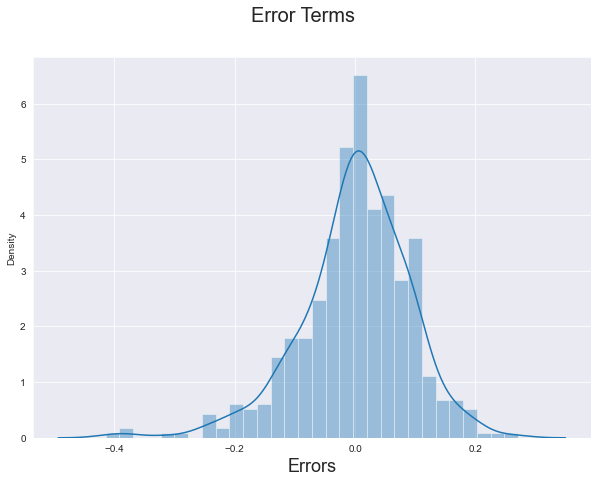

In [60]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_preds), bins = 30)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

Clearly, the error terms are centered around 0 and are normally distributed. So the assumption holds true.

### Making Predictions

In [62]:
# scale numeric columns of test set
df_test[numeric_features] = scaler.transform(df_test[numeric_features])

In [63]:
y_test = df_test.pop('cnt')
X_test = df_test

In [64]:
#drop all insignificant columns and make predictions on the test set
X_test_new = sm.add_constant(X_test)
X_test_new = X_test_new[X_train_rfe.columns]

In [65]:
y_preds = model.predict(X_test_new)

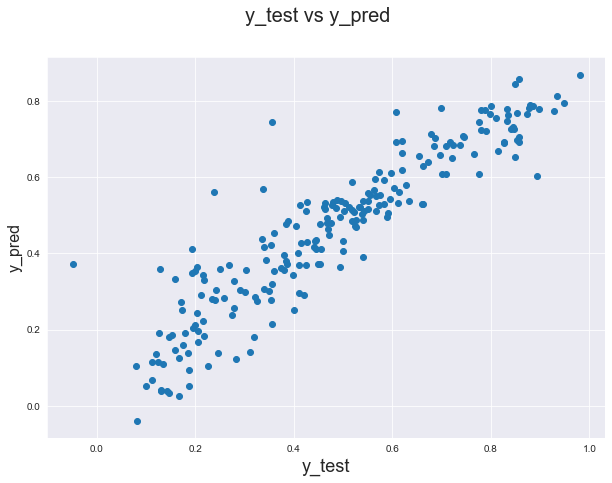

In [66]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_preds)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label
plt.show()

The predictions seems to obey the principle of `Homoscedasticity`. 

In [67]:
# R2_Score on test set
print(f'Coefficient of determination (R2 Score) for the test set: {r2_score(y_test,y_preds)*100:.2f} %')

Coefficient of determination (R2 Score) for the test set: 83.35 %


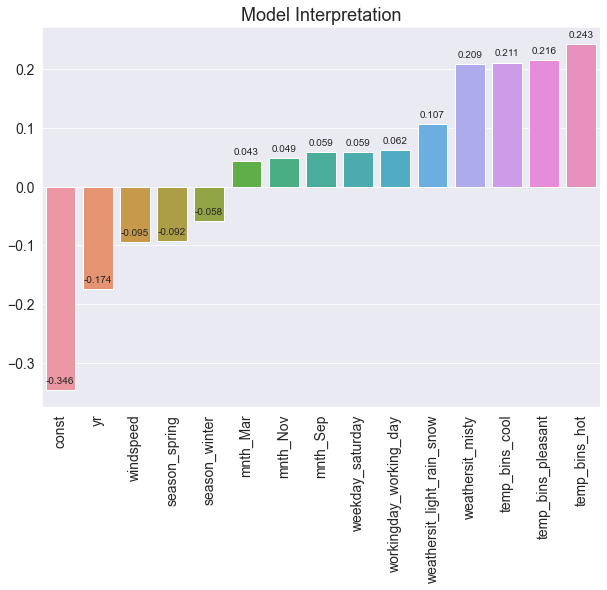

In [68]:
plt.title('Model Interpretation',fontsize = 18)
coefficient_plot = sns.barplot(data=model.params,x = list(model.params.index),y=list(np.log(model.params.values+1)))
for p in coefficient_plot.patches:
    coefficient_plot.annotate(format(p.get_height(), ',.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xticks(ticks = range(len(model.params.index)), labels= list(model.params.index),rotation=90,fontsize = 14 )
plt.yticks(fontsize = 14 )
plt.show()

The above plot gives us an idea of the coefficients and the respective positive or negative impact on the target variable.